# Advanced baseline processing

This notebook demonstrates how one can remove a baseline from the data. IMPORTANT: It requires that the resonance is much narrower than the changes in the baseline and that a sufficiently large part of the baseline is recorded.

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
%matplotlib inline

## 1. Flat Baseline

First, we generate some fake data which we can fit later:

In [185]:
from resonator_tools import circuit
fr = 7e9  #resonance frequency in Hz
Qi = 200e3
Qc = 300e3
freq = np.linspace(fr-5e6, fr+5e6, 5000)
port1 = circuit.reflection_port()  #define a reflection port
noise = np.random.normal(loc=1.0,scale=0.01,size=(len(freq),))
S11 = noise * port1._S11_directrefl(freq,fr=fr,Ql=Qi*Qc/(Qc+Qi),Qc=Qc,a=1.,alpha=0.,delay=.0)
port1.add_data(freq,S11)

Let's plot the data:

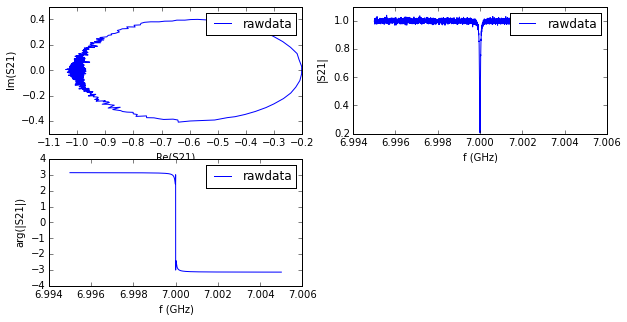

In [186]:
plt.rcParams["figure.figsize"] = [10,5]
port1.plotrawdata()

...and fit it: (since we know the electric delay, we tell it the program, this makes it more accurate)

In [187]:
port1.autofit(electric_delay=0.)

...and plot the result:

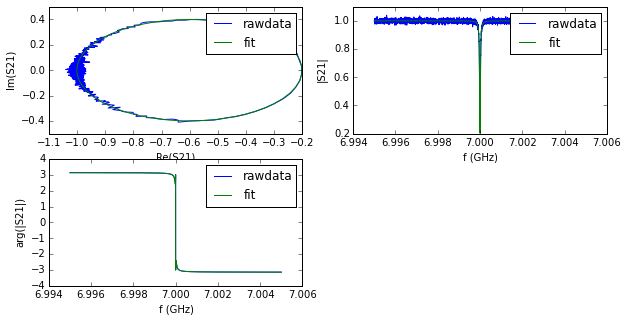

In [188]:
port1.plotall()

Next, let us have a look at the fit results. Here, we convert the dictionary of results into a dataframe to display it in a nicer way.

In [189]:
display(pd.DataFrame([port1.fitresults]).applymap(lambda x: "{0:.2e}".format(x)))

,Qc,Qc_err,Qi,Qi_err,Ql,Ql_err,chi_square,fr,fr_err,theta0
0,2.99e+05,1.08e+03,1.99e+05,1.41e+03,1.20e+05,6.21e+02,1.01e-04,7.00e+09,1.15e+02,2.20e-03


## 2. Wavy Baseline

Remember to think before removing a baseline if it is justified to do that!

Generate some low frequency signals:

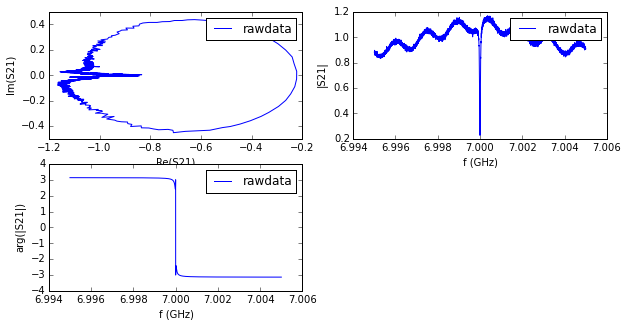

In [190]:
baseline = 1+0.1*np.cos(2.*np.pi*0.001e-4*freq)+0.05*np.sin(2.*np.pi*0.0069e-4*freq)+0.001*np.sin(2.*np.pi*0.0001e-4*freq)
S11b = port1.z_data*baseline
port2 = circuit.reflection_port() 
port2.add_data(freq,S11b)
port2.plotrawdata()

Here, the problem is clearly in the amplitude signal. The following procedure would also work for the phase signal:

        see http://zanran_storage.s3.amazonaws.com/www.science.uva.nl/ContentPages/443199618.pdf
        "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens in 2005.
        http://stackoverflow.com/questions/29156532/python-baseline-correction-library
        "There are two parameters: p for asymmetry and lambda for smoothness. Both have to be
        tuned to the data at hand. We found that generally 0.001<=p<=0.1 is a good choice
        (for a signal with positive peaks) and 10e2<=lambda<=10e9, but exceptions may occur."

In [191]:
from resonator_tools import calibration

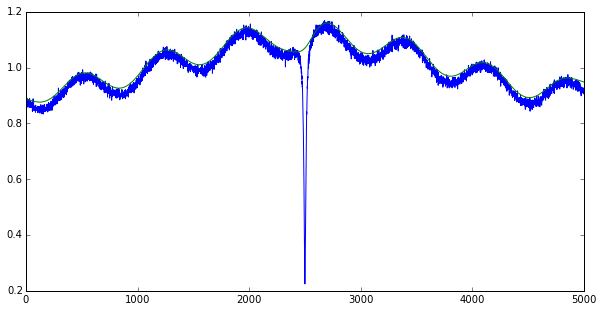

In [192]:
lam = 1e6#smoothness
p = 0.99  #asymmetry
fitted_baseline = port2.fit_baseline_amp(port2.z_data_raw,lam,p,niter=10)
plt.plot(np.absolute(port2.z_data_raw))
plt.plot(fitted_baseline)

The computed baseline marks the upper bound of the data. We need to shift it manually a bit such that it is in the middle of the noise.

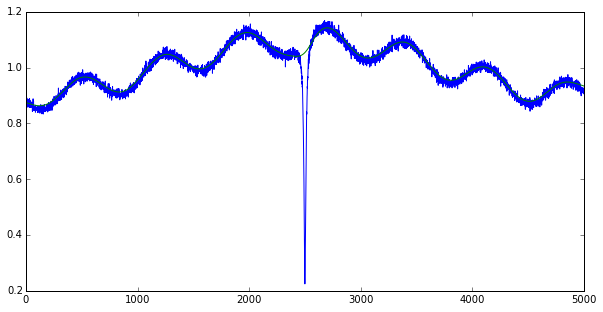

In [193]:
base_correct = 0.985
plt.plot(np.absolute(port2.z_data_raw))
plt.plot(fitted_baseline*base_correct)

Now we normalize and fit and plot everything. Cutting the data around the resonance for the final fit helps a lot:

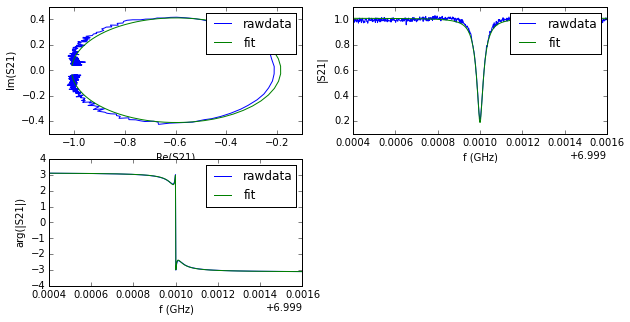

In [194]:
port3 = circuit.reflection_port() 
port3.add_data(freq[2200:2800],(S11b/(fitted_baseline*base_correct))[2200:2800])
port3.autofit(electric_delay=0.)
port3.plotall()

Below, the comparison of the data fitted without(row 0) wiggly baseline and after adding and removing the basline (row 1).

In [195]:
display(pd.DataFrame([port1.fitresults,port3.fitresults]).applymap(lambda x: "{0:.2e}".format(x)))

,Qc,Qc_err,Qi,Qi_err,Ql,Ql_err,chi_square,fr,fr_err,theta0
0,2.99e+05,1.08e+03,1.99e+05,1.41e+03,1.20e+05,6.21e+02,1.01e-04,7.00e+09,1.15e+02,2.20e-03
1,3.10e+05,1.69e+03,2.14e+05,2.93e+03,1.27e+05,1.21e+03,2.59e-04,7.00e+09,1.51e+02,-1.09e-03


Don't expect miracles!